## Imports

### Python numerical modules

In [1]:
import pandas as pd

### Machine learning

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 

### Python

In [3]:
import re, sys, os

from linecache import getline
from pathlib import Path

sys.path.append(str(Path(os.getcwd()).parent) + '\Modules\py')

### Custom modules

In [4]:
import Constants as c

## Learning to classify edges

In [5]:
cvrp = pd.read_csv('../Data/data.csv', index_col=0)
cvrp

,U_NODE_ID,V_NODE_ID,U_X,U_Y,V_X,V_Y,IS_DEPOT,IS_OPTIMAL_EDGE,EDGE_WEIGHT,GLOBAL_RANK,...,LP_RELAXATION,FILE_NAME,U_NODE_DEMAND,V_NODE_DEMAND,CAPACITY,NUM_OF_VEHICLES,U_NODE_DEMAND_CAPACITY_RATIO,V_NODE_DEMAND_CAPACITY_RATIO,REDUCED_COST,MST_WEIGHT
0,1,2,82,76,96,44,1,0,34.928498,352,...,0.0,A-n32-k5.txt,0,19,100,5,0.000000,0.190,24.551054,34.928498
1,1,3,82,76,50,5,1,0,77.878110,136,...,0.0,A-n32-k5.txt,0,21,100,5,0.000000,0.210,70.461782,77.878110
2,1,4,82,76,49,8,1,0,75.584390,148,...,0.0,A-n32-k5.txt,0,6,100,5,0.000000,0.060,70.041266,75.584390
3,1,5,82,76,13,7,1,0,97.580736,37,...,0.0,A-n32-k5.txt,0,19,100,5,0.000000,0.190,87.135763,97.580736
4,1,6,82,76,29,89,1,1,54.571055,261,...,0.0,A-n32-k5.txt,0,7,100,5,0.000000,0.070,36.076898,54.571055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46904,57,59,6,25,40,60,0,0,48.795492,204,...,0.0,P-n60-k10.txt,26,21,120,1,0.216667,0.175,35.711874,48.795492
46905,57,60,6,25,50,4,0,0,48.754487,205,...,0.0,P-n60-k10.txt,26,24,120,1,0.216667,0.200,33.689178,48.754487
46906,58,59,65,27,40,60,0,0,41.400483,333,...,0.0,P-n60-k10.txt,14,21,120,1,0.116667,0.175,30.797363,41.400483
46907,58,60,65,27,50,4,0,0,27.459060,557,...,0.0,P-n60-k10.txt,14,24,120,1,0.116667,0.200,14.874248,27.459060


### Removing useless features

In [6]:
cvrp.pop(c.U_NODE_ID)
cvrp.pop(c.V_NODE_ID)
cvrp.pop(c.U_Y)
cvrp.pop(c.U_X)
cvrp.pop(c.V_X)
cvrp.pop(c.V_Y)
cvrp.pop(c.FILE_NAME)

y = cvrp.pop(c.IS_OPTIMAL_EDGE).values
X = cvrp.values

### Train test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40)

scaler = MinMaxScaler()
normalised_X = scaler.fit_transform(X_train)
normalised_X.shape

normalised_test_X = scaler.fit_transform(X_test)
normalised_test_X.shape

(18764, 23)

### Ranking features

In [8]:
from sklearn.feature_selection import mutual_info_classif

i_scores = mutual_info_classif(normalised_X, y_train)

X_train_df = pd.DataFrame(data=normalised_X, columns=list(cvrp.columns))
X_train_df

FS_DF = pd.DataFrame(i_scores, index = X_train_df.columns, columns = ['I-Gain'])
FS_DF.sort_values(by=['I-Gain'], ascending=False, inplace=True)
FS_DF

,I-Gain
V_NODE_LOCAL_EDGE_RANK,0.020924
U_NODE_LOCAL_EDGE_RANK,0.019119
EDGE_WEIGHT,0.017320
MST_U_DEGREE,0.017215
U_NODE_DEMAND,0.016754
IS_MST_EDGE,0.016593
MST_WEIGHT,0.016036
U_NODE_DEMAND_CAPACITY_RATIO,0.015111
IS_DEPOT,0.014560
REDUCED_COST,0.013463


### Getting best features and training model

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

def train_model(classifier, is_knn):
    best_n_features = 1
    best_acc = 0
    best_k = 1
    best_score = []
    
    for k in range(1, 10):
        scores = []
        model = KNeighborsClassifier(k) if is_knn else classifier
        for up_to_index_feature in range(1, len(FS_DF.index) + 1):
            selected_features = X_train_df[FS_DF.index[:up_to_index_feature]]
            top_selected_features = selected_features.values
            curr_acc = cross_val_score(model, top_selected_features, y_train, cv=10, scoring='f1_macro')[0]

            scores.append(curr_acc)

            if (curr_acc > best_acc):
                best_acc = curr_acc
                best_n_features = up_to_index_feature
                best_k = k
                best_score = scores

    FS_DF.head(n=best_n_features)

    selection = SelectKBest(score_func=mutual_info_classif, k=best_n_features).fit(X_train, y_train)
    X_features = selection.transform(X_train)
    print(X_features.shape)
    print(best_k)

    model = KNeighborsClassifier(best_k) if is_knn else classifier
    model.fit(X_features, y_train)

    X_test_features = selection.transform(normalised_test_X)
    y_pred = model.predict(X_test_features)
    
    matrix = classification_report(y_test, y_pred)
    print('Classification report : \n',matrix)

    print("Accuracy:\n{}".format(accuracy_score(y_test, y_pred)))

    plot_confusion_matrix(model, X_test_features, y_test)
    confusion = confusion_matrix(y_test, y_pred)
    print("\nConfusion matrix:\n{}".format(confusion))

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## kNN

KNN
(28145, 4)
1


c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     18087
           1       0.00      0.00      0.00       677

    accuracy                           0.96     18764
   macro avg       0.48      0.50      0.49     18764
weighted avg       0.93      0.96      0.95     18764

Accuracy:
0.963920272862929

Confusion matrix:
[[18087     0]
 [  677     0]]


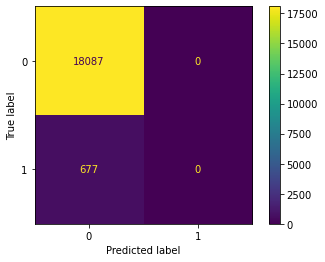

In [11]:
print("KNN")
train_model(KNeighborsClassifier(), True)

## GaussianNB


GNB
(28145, 9)
1
Classification report : 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     18087
           1       0.28      0.26      0.27       677

    accuracy                           0.95     18764
   macro avg       0.62      0.62      0.62     18764
weighted avg       0.95      0.95      0.95     18764

Accuracy:
0.9484651460243019

Confusion matrix:
[[17619   468]
 [  499   178]]


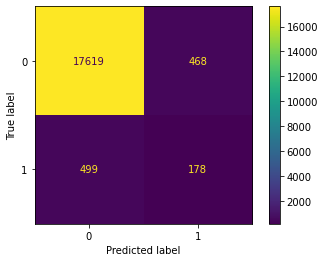

In [12]:
print("\nGNB")
train_model(GaussianNB(), False)

## BernoulliNB


BNB
(28145, 5)
1
Classification report : 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     18087
           1       0.13      0.10      0.11       677

    accuracy                           0.94     18764
   macro avg       0.55      0.54      0.54     18764
weighted avg       0.94      0.94      0.94     18764

Accuracy:
0.9414836921765082

Confusion matrix:
[[17595   492]
 [  606    71]]


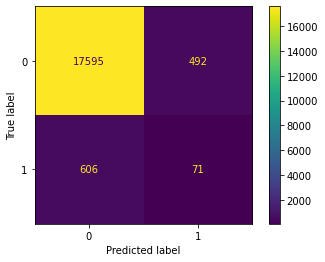

In [13]:
print("\nBNB")
train_model(BernoulliNB(), False)

## LogisticRegression


LR
(28145, 6)
1
Classification report : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     18087
           1       0.00      0.00      0.00       677

    accuracy                           0.96     18764
   macro avg       0.48      0.50      0.49     18764
weighted avg       0.93      0.96      0.95     18764

Accuracy:
0.963920272862929

Confusion matrix:
[[18087     0]
 [  677     0]]


c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

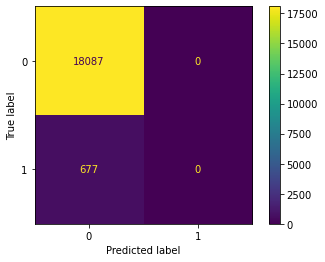

In [14]:
print("\nLR")
train_model(LogisticRegression(), False)

## DecisionTreeClassifier


DTC
(28145, 4)
4
Classification report : 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     18087
           1       0.05      0.02      0.03       677

    accuracy                           0.95     18764
   macro avg       0.51      0.50      0.50     18764
weighted avg       0.93      0.95      0.94     18764

Accuracy:
0.9518759326369644

Confusion matrix:
[[17849   238]
 [  665    12]]


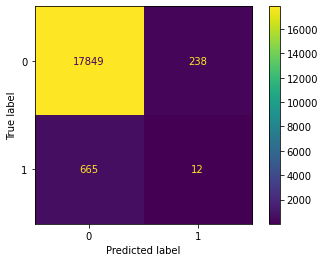

In [15]:
print("\nDTC")
train_model(DecisionTreeClassifier(), False)

## SVC


SVC
(28145, 18)
1


c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bigbadbraddy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     18087
           1       0.00      0.00      0.00       677

    accuracy                           0.96     18764
   macro avg       0.48      0.50      0.49     18764
weighted avg       0.93      0.96      0.95     18764

Accuracy:
0.963920272862929

Confusion matrix:
[[18087     0]
 [  677     0]]


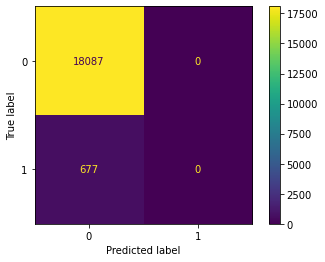

In [16]:
print("\nSVC")
train_model(SVC(), False)